# Syntax Parsing and Statistical Machine Translation

In this session we will see how to use NLTK for PCFGs and Statistical Machine Translation

## 1. Constituent-based syntactic parsing

First of all, we will need to import nltk as usual and the nltk corpus of parsed WSJ treebank. This is a small portion of the WSJ treebank, but it will be enough for our purposes.

In [2]:
import nltk

nltk.download("treebank")

print(treebank.parsed_sents("wsj_0001.mrg")[0])

[nltk_data] Downloading package treebank to
[nltk_data]     /Users/maximemoutet/nltk_data...


(S
  (NP-SBJ
    (NP (NNP Pierre) (NNP Vinken))
    (, ,)
    (ADJP (NP (CD 61) (NNS years)) (JJ old))
    (, ,))
  (VP
    (MD will)
    (VP
      (VB join)
      (NP (DT the) (NN board))
      (PP-CLR (IN as) (NP (DT a) (JJ nonexecutive) (NN director)))
      (NP-TMP (NNP Nov.) (CD 29))))
  (. .))


[nltk_data]   Unzipping corpora/treebank.zip.


This method is part of the Tree NLTK class and has methods to read parse trees in bracketed format:

In [8]:
from nltk import Tree

s = "(S (NP (DT the) (NN cat)) (VP (VBD ate) (NP (DT a) (NN cookie))))"
t = Tree.fromstring(s)
print(t)

(S (NP (DT the) (NN cat)) (VP (VBD ate) (NP (DT a) (NN cookie))))


Let's see some other useful methods for the **Tree** class:

- Transforming the tree in Chomsky’s Normal Form:

In [9]:
t.chomsky_normal_form()

Obtaining the productions from a parse tree:

In [10]:
t.productions()

[S -> NP VP,
 NP -> DT NN,
 DT -> 'the',
 NN -> 'cat',
 VP -> VBD NP,
 VBD -> 'ate',
 NP -> DT NN,
 DT -> 'a',
 NN -> 'cookie']

For every production we can get the left and right parts of the productions:

In [11]:
for p in t.productions():
    print(p.lhs())  # left part (nonterminal)
    print(p.rhs())  # right part of the rule (sequence)

S
(NP, VP)
NP
(DT, NN)
DT
('the',)
NN
('cat',)
VP
(VBD, NP)
VBD
('ate',)
NP
(DT, NN)
DT
('a',)
NN
('cookie',)


### 1.1 Context-Free Grammars

NLTK includes several classes to encode CFG and PCFG grammars in the nltk.grammar module:

1.	Nonterminal
2.	Production (for rules)
3.	WeightedProduction (for rules in a PCFG)
4.	ContextFreeGrammar
5.	PCFG

The classes include convenient parsers to convert strings into grammars. The method *grammar.check_coverage(ws)* determines whether the words that appear in *ws* can ever be parsed by the grammar.

In [12]:
from nltk import nonterminals, Nonterminal, Production

# Create some nonterminals
S, NP, VP, PP, VB, NN = nonterminals("S, NP, VP, PP, VB, NN")
N, V, P, Det = nonterminals("N, V, P, Det")
# Create a production rule and print it
print(Production(S, [NP, VP]))

S -> NP VP


**Exercise 1**. Using the NLTK classes to encode elements of CFG grammars, estimate the probability of observing the rule 'NP -> NP PP' and the rule 'VP -> VB NP'

Remember that the probability for productions is estimated as:

$$p( X \to \alpha) =  \frac{c( X \to \alpha )}{c(X)}$$

In [14]:
# Suggestion: the following code helps browsing the treebank

productions = []
for item in treebank.fileids():
    for tree in treebank.parsed_sents(item):
        tree.chomsky_normal_form()  # Don’t forget to normalize in CNF the parse tree
        productions += tree.productions()

### 1.2 Moving to Probabilistic Context-Free Grammars

NLTK can do the work of inducing a PCFG from an existing Treebank. Once we have stored in productions all the productions from our treebank, we can obtain the PCFG as follows:

In [15]:
from nltk import Nonterminal

S = Nonterminal("S")
grammar = nltk.grammar.induce_pcfg(S, productions)

**Exercise 2**. Compare the values obtained in exercise 1 to those calculated automatically by the induce_pcfg method. (Hint: grammar.productions() to navigate through the productions of the grammar).

In [16]:
nonter = NP
seq = (NP, PP)

for p in grammar.productions():
    if p.lhs() == nonter:
        if p.rhs() == seq:
            print(p)

NP -> NP PP [0.0922273]


### 1.3 Parsing

There are different types of parsers implemented in NLTK. One that implements the Viterbi CKY n-best parses over a PCFG is available in the *parse.viterbi* module:

In [17]:
for p in grammar.productions():
    if p.lhs() == NN:
        if p.rhs()[0].startswith("tel"):
            print(p)

NN -> 'television' [0.000683579]
NN -> 'telephone' [0.000759532]
NN -> 'telecommunications' [7.59532e-05]
NN -> 'telegraph' [7.59532e-05]
NN -> 'telephone-information' [7.59532e-05]


In [18]:
from nltk.parse import ViterbiParser

s = "I saw John with my telephone"
tokens = s.split()  # simplified – you can use a tokenizer
parser = ViterbiParser(grammar)  # using the grammar induced by the Treebank
parses = parser.parse_all(tokens)  # the resulting parse tree

## 2. Statistical Machine Translation

Objective: learn word alignments from a parallel corpus

NLTK includes an implementation of the IBM Model 1 in the package **nltk.align.ibm1** ; we will use this implementation to calculate a lexical translation dictionary.

First of all, we need to load the parallel corpus:

In [21]:
nltk.download("comtrans")

data = comtrans.aligned_sents(
    "alignment-en-fr.txt"
)  # this will load the alignments English-French

print(data[0])
print(len(data))

[nltk_data] Downloading package comtrans to
[nltk_data]     /Users/maximemoutet/nltk_data...


<AlignedSent: 'Resumption of the se...' -> 'Reprise de la sessio...'>
33334


Now we can import the IBM Model 1 implementation and build the model (this will take some time):

In [22]:
from nltk import IBMModel1

# model=IBMModel1(data, 30) #data is the parallel corpus, 30 is the number of iterations for the EM algorithm

# to reduce the waiting time we can work on a smaller dataset:
model = IBMModel1(data[:10], 30)  # or reduce the iterations for the EM algorithm

At this point we can look at the translation table to find the translation probabilities estimated by the IBM Model1:

In [23]:
print(model.translation_table["the"]["le"])
print(model.translation_table["the"]["la"])

1.3424467563162238e-05
0.13410723057727778


**Exercise 4**. Use a corpus of different sizes (10, 20, 30, 40 … 100) and max 30 iterations. Study the variation of the value of the probability of finding “le” given “the” (model.translation_table["the"]["le"]). Plot the result.


In [28]:
probs = []

for size in range(10, 110, 10):
    model = IBMModel1(data[:size], 30)
    probs.append(model.translation_table["the"]["le"])

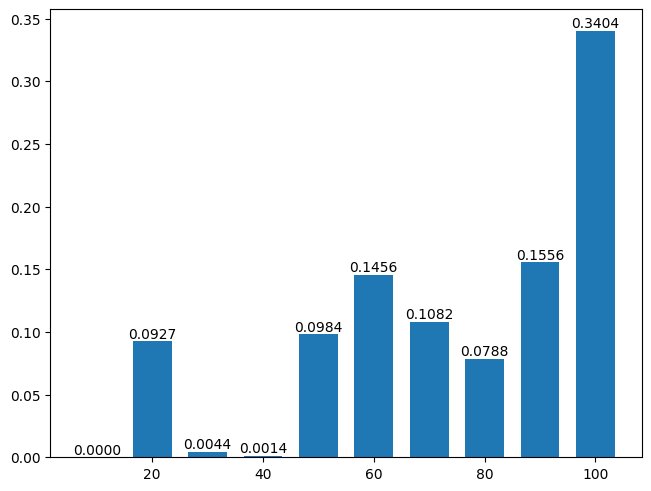

In [44]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(layout="constrained")
for i, x in enumerate(range(10, 110, 10)):
    rects = ax.bar(x, probs[i], width=7, color="tab:blue")
    ax.bar_label(rects, fmt="%.4f")

**Exercise 5**. Try with a model of fixed size (100) while varying the number of iterations between 30 and 100 (step 10) and plot the result. Then try with a model of fixed size (50). Compare the behaviour of the models.

In [45]:
probs = []
for iterations in range(30, 110, 10):
    model = IBMModel1(data[:100], iterations)
    probs.append(model.translation_table["the"]["le"])

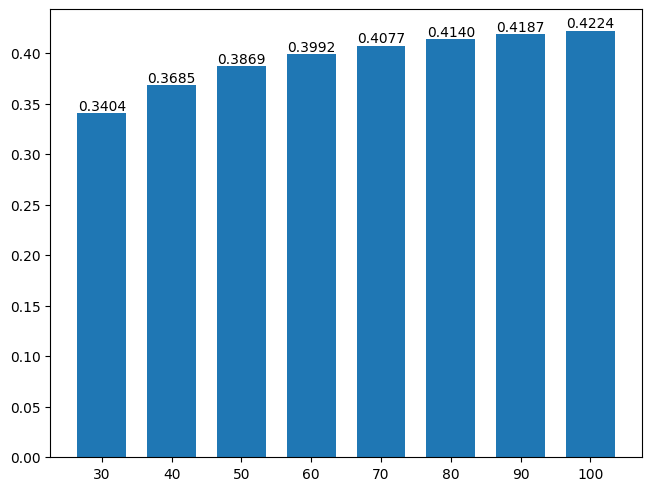

In [46]:
fig, ax = plt.subplots(layout="constrained")
for i, x in enumerate(range(30, 110, 10)):
    rects = ax.bar(x, probs[i], width=7, color="tab:blue")
    ax.bar_label(rects, fmt="%.4f")

**Exercise 6**. Take the model built using 100 pairs of sentences and look at the values for [“dog”][“chien”] and ["is"]["est"]. What can you deduce about the underlying model?

In [47]:
print(model.translation_table["dog"]["chien"])
print(model.translation_table["is"]["est"])

1e-12
0.7941916959822813


<b>Exercise 7.</b> (optional) Take a look at the multi-head alignments obtained for an en-fr NMT model below. Consider the encoder attention alone, decoder attention alone and the cross-attention.
Test the result for the first 2 sentences in the file ```alignment-en-fr.txt``` : can you identify the role of some of the most important heads? Can you tell how many heads are actually contributing to the MT task?

In [26]:
from transformers import AutoTokenizer, AutoModel, utils
from bertviz import model_view

utils.logging.set_verbosity_error()  # Remove line to see warnings

# Initialize tokenizer and model. Be sure to set output_attentions=True.
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-fr-en")
model = AutoModel.from_pretrained("Helsinki-NLP/opus-mt-fr-en", output_attentions=True)

# get encoded input vectors
encoder_input_ids = tokenizer(
    "She sees the small elephant.", return_tensors="pt", add_special_tokens=True
).input_ids

# create ids of encoded input vectors
with tokenizer.as_target_tokenizer():
    decoder_input_ids = tokenizer(
        "Elle voit le petit éléphant.", return_tensors="pt", add_special_tokens=True
    ).input_ids

outputs = model(input_ids=encoder_input_ids, decoder_input_ids=decoder_input_ids)

encoder_text = tokenizer.convert_ids_to_tokens(encoder_input_ids[0])
decoder_text = tokenizer.convert_ids_to_tokens(decoder_input_ids[0])

model_view(
    encoder_attention=outputs.encoder_attentions,
    decoder_attention=outputs.decoder_attentions,
    cross_attention=outputs.cross_attentions,
    encoder_tokens=encoder_text,
    decoder_tokens=decoder_text,
)

/Users/maximemoutet/.pyenv/versions/3.11.5/envs/venv-nlp/lib/python3.11/site-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/Users/maximemoutet/.pyenv/versions/3.11.5/envs/venv-nlp/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:3892: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


<IPython.core.display.Javascript object>